In [1]:
import numpy as np
import keras
from keras.layers import Dense, Activation, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import LeakyReLU, Input, Reshape, Conv2DTranspose, UpSampling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [8]:
try:
    discriminator = load_model('discriminator.h5')
except:
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64,(3,3), activation='relu',input_shape=(28,28,1)))
    discriminator.add(Conv2D(64,(3,3), activation='relu'))
    discriminator.add(MaxPooling2D((2,2)))
    
    discriminator.add(Conv2D(64,(3,3), activation='relu'))
    discriminator.add(Conv2D(64,(3,3), activation='relu'))
    discriminator.add(MaxPooling2D((2,2)))
    
    discriminator.add(Conv2D(64,(3,3), activation='relu'))
    discriminator.add(Flatten())
    
    discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

W0704 18:05:35.582295 140575307949952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 18:05:35.584968 140575307949952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 18:05:35.588042 140575307949952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 18:05:35.615741 140575307949952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0704 18:05:35.675508 140575307949952 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          36928     
__________

In [9]:
try:
    generator = load_model('generator.h5')
except:
    generator = Sequential()
    generator.add(Dense(800, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Reshape((5,5,32)))
    generator.add(UpSampling2D((2,2)))
    generator.add(Conv2DTranspose(256,(3,3),activation='relu'))
    
    generator.add(UpSampling2D((2,2)))
    generator.add(Conv2DTranspose(128,(3,3),activation='relu'))
    generator.add(Conv2DTranspose(1,(3,3),activation='relu'))
    generator.add(Activation('tanh'))
    
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

W0704 18:05:35.757119 140575307949952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 800)               80800     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 800)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 32)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 256)       73984     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 128)       295040    
__________

In [0]:
y_train = np_utils.to_categorical(y_train)

In [11]:
y_train.shape,X_train.shape

((60000, 10), (60000, 28, 28))

In [0]:
X_train = X_train.astype('float64')
X_train /= 255
X_test = X_test.astype('float64')
X_test /= 255

In [0]:
X_train = X_train.reshape(len(X_train),28,28,1)

In [15]:
y_train.shape,X_train.shape

((60000, 10), (60000, 28, 28, 1))

In [16]:
try:
    gan = load_model( 'gan.h5')
except:
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(100,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         450977    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 148609    
Total params: 599,586
Trainable params: 450,977
Non-trainable params: 148,609
_________________________________________________________________


In [0]:
def plot_loss(losses):
    d_loss = losses['D']
    g_loss = losses['G']
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [0]:
def plot_generated(figsize=(12, 2)):
    noise = (np.random.random_sample((10,100))*2 - 1)
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(10, 28, 28)
#     generated_images -= 1
#     generated_images *=255
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

W0704 18:05:36.416211 140575307949952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



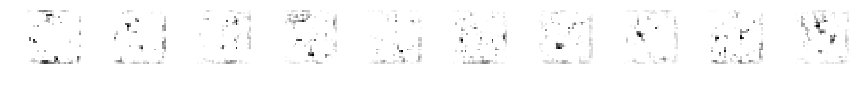

In [19]:
plot_generated()

In [0]:
def train(epoch=1, ploting_ep = 20 , batch_size=128):
    losses = {'D':[],'G':[]}
    batch_count = X_train.shape[0] // batch_size
    for i in range(1,epoch+1):
        for j in range(batch_count):
            # Input for the generator
            noise_input = (np.random.random_sample((batch_size,100))*2 - 1)

            # getting images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[j*batch_size:(j+1)*batch_size]

            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([ image_batch,predictions])
            # labels for the discriminator
            y_discriminator = np.zeros(2*batch_size)
            y_discriminator[:batch_size] = 1
            # Let's train the discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_discriminator)

            # Let's train the generator
            y_generator = np.ones(batch_size)
            discriminator.trainable = False
            
            g_loss = gan.train_on_batch(noise_input, y_generator)
        losses['D'].append(d_loss)
        losses['G'].append(g_loss)
        print("Epoch :  {0}/{1}  Dicriminator Loss : {2:.2f}  Generator Loss : {3:.2f}".format(i,epoch,d_loss,g_loss))
        if i==1 or i%ploting_ep==0:
            plot_generated()
    plot_loss(losses)
    return losses

Epoch :  1/20  Dicriminator Loss : 0.41  Generator Loss : 1.92


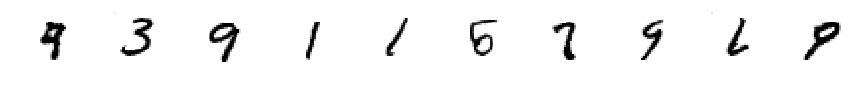

Epoch :  2/20  Dicriminator Loss : 0.37  Generator Loss : 2.10
Epoch :  3/20  Dicriminator Loss : 0.43  Generator Loss : 2.01
Epoch :  4/20  Dicriminator Loss : 0.35  Generator Loss : 1.81
Epoch :  5/20  Dicriminator Loss : 0.39  Generator Loss : 2.09


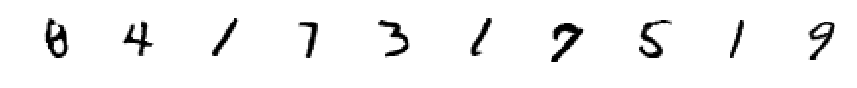

Epoch :  6/20  Dicriminator Loss : 0.36  Generator Loss : 2.27
Epoch :  7/20  Dicriminator Loss : 0.32  Generator Loss : 1.86
Epoch :  8/20  Dicriminator Loss : 0.37  Generator Loss : 1.92
Epoch :  9/20  Dicriminator Loss : 0.35  Generator Loss : 1.99
Epoch :  10/20  Dicriminator Loss : 0.37  Generator Loss : 1.91


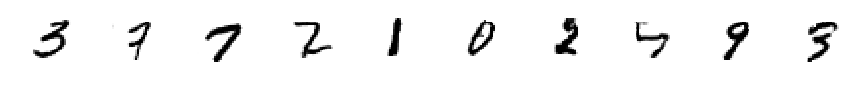

Epoch :  11/20  Dicriminator Loss : 0.35  Generator Loss : 2.00
Epoch :  12/20  Dicriminator Loss : 0.39  Generator Loss : 2.52
Epoch :  13/20  Dicriminator Loss : 0.39  Generator Loss : 2.40
Epoch :  14/20  Dicriminator Loss : 0.39  Generator Loss : 2.76
Epoch :  15/20  Dicriminator Loss : 0.33  Generator Loss : 2.25


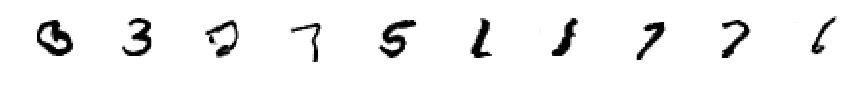

Epoch :  16/20  Dicriminator Loss : 0.34  Generator Loss : 2.20
Epoch :  17/20  Dicriminator Loss : 0.37  Generator Loss : 2.51
Epoch :  18/20  Dicriminator Loss : 0.35  Generator Loss : 2.55
Epoch :  19/20  Dicriminator Loss : 0.35  Generator Loss : 2.76
Epoch :  20/20  Dicriminator Loss : 0.29  Generator Loss : 2.42


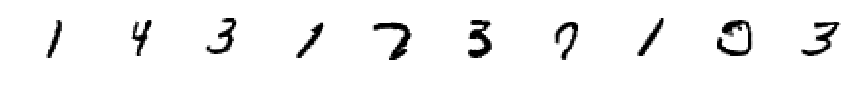

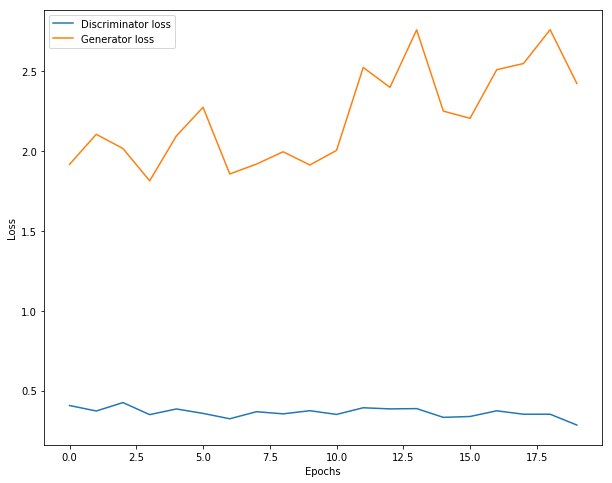

CPU times: user 5min 32s, sys: 2min 44s, total: 8min 16s
Wall time: 9min 35s


In [22]:
%%time
losses = train(20,5)

In [0]:
gan.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')